[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# One Dimensional Kalman Filters

In [1]:
#format the book
%matplotlib inline
%load_ext autoreload
%autoreload 2  
from __future__ import division, print_function
import sys
import warnings
warnings.filterwarnings('ignore')
sys.path.insert(0,'./code')
from book_format import load_style
load_style()

## One Dimensional Kalman Filters

Now that we understand the discrete Bayes filter and Gaussians we are prepared to implement a Kalman filter. We will do this exactly as we did the discrete Bayes filter - rather than starting with equations we will develop the code step by step based on reasoning about the problem. "One dimensional" just means that the filter only tracks one variable, such as position on the x-axis. In the subsequent chapters we will learn a more general form that can track many variables simultaneously, such as position, velocity, and accelerations in x, y, z. 

## Tracking A Dog

As in the **Discrete Bayes Filter** chapter we will be tracking a moving object in a long hallway at work, such as a dog or robot. Assume that in our latest hackathon someone created an RFID tracker that provides a reasonably accurate position for our dog. Suppose the hallway is 100 meters long. The sensor returns the distance of the dog from the left end of the hallway in meters. So, 23.4 would mean the dog is 23.4 meters from the left end of the hallway.

Naturally, the sensor is not perfect. A reading of 23.4 could correspond to a real position of 23.7, or 23.0. However, it is very unlikely to correspond to a real position of say 47.6. Testing during the hackathon confirmed this result - the sensor is 'reasonably' accurate, and while it had errors, the errors are small. Furthermore, the errors seemed to be evenly distributed on both sides of the measurement; a true position of 23 m would be equally likely to be measured as 22.9 as 23.1.

Before we try to implement the filter, let's start by implementing a simulation of the dog's movement and of the sensor. After all, the filter needs to filter data collected from the dog, so we need to understand this movement and sensor behavior to have any hope of filtering it.

### Simulating the Sensor Measurement

Accurately simulating an RFID tracker is beyond the scope of this book, so we will use a simple model. We said that the sensor is equally likely to give a measurement that is too large as too small. Furthermore, it is more likely to be a small error than a large one. In the **Discrete Bayes** chapter we modelled this error with a probability. But now we understand Gaussians so let's use them instead. We can model the error in a system with the Gaussian $\mathcal{N}(\mu, \sigma^2)$, where $\mu$ is the state (such as position or velocity) and $\sigma^2$ is the variance in that state. So instead of saying our measurement is 22.9, we would say our measurement is 22.9 with a variance of 0.35, or $\mathcal{N}(22.9, 0.35)$. The variance accounts for the error in the sensor.

This is a simple model, but it works very well in practice. Error distributions of many sensors approximate a normal distribution. Of course, if the sensor errors are not well modelled by Gaussians your simulations of the filter performance are likely to mislead you.

In the literature you will often see this charaterized with an equation like:

$$ z = h(x) + \epsilon_z$$

Here $h(x)$ is the **measurement model** - a function which describes how measurements are made from the current system state. In other words, $h(x)$ is the measurement we would get for the state $x$ *if* the sensor was perfect. $\epsilon_z$ is the error that is in the measurement, and hence $z$ is the actual measurement that results. This is not meant to imply that we can somehow measure or know the exact value of $\epsilon_z$, it is a mathematical definition that can be restated as

$$ \epsilon_z =  z - h(x)$$

The utility of this equation will become apparent later in the book. For now recognize that we will be modelling $\epsilon_z$ with a Gaussian. If $\epsilon_z$ is close to being Gaussian our model will be accurate, and if it is not our model may not work well.

### Simulating the Dog's movement

Let's assume that the dog moves at a constant velocity. We can use Newton's equation to compute the new position based on the current velocity and previous position like so:

$$ x_k = v_k \Delta t + x_{k-1}$$.

This is a model of the dog's behavior, and we call it the *system model* or *process model*. However, clearly it is not perfect. The dog might speed up or slow down due to hills, winds, or whimsy. We could add those things to the model if we knew about them, but there will always be more things that we don't know. This is not due to the tracked object being a living creature. The same holds if we are tracking a missile, aircraft, or paint nozzle on a factory robotic painter. There will always be unpredictable errors in physical systems. We can model this mathematically by saying the dog's actual position is the prediction that comes from our process model plus what we call the *process noise*. In the literature this is usually written something like this:

$$ x = f(x) +\epsilon$$

Here $f(x)$ is our process model and $\epsilon$ is some unknown error between the process model's prediction of position and the actual position. Clearly $\epsilon$ will change over time, and as with the measurement equation in the last section we are not implying that $\epsilon$ can be derived analytically.

### Implemention in Python

We will want our implementation to correctly model the noise both in the measurement and the process model. You may recall from the **Gaussians** chapter that we can use `numpy.random.randn()` to generate a random number with a mean of zero and a standard deviation of one. Thus, if we want a random number with a standard deviation of 0.5 we'd multipy the value returned by `randn()` by 0.5. 

Our model assumes that the velocity of our dog is constant, but things like hills and obstacles make that very unlikely to be true. We can simulate this by adding a randomly generated value to the velocity each time we compute the dog's position.

```python
noisy_vel = vel + randn()*velocity_std
x = x + noisy_vel*dt
```
 

To model the sensor we need to take the current position of the dog and then add some noise to it proportional to the Gaussian of the measurement noise. This is simply

```python
z = x + randn()*measurement_std
```
    
I don't like the bookkeeping required to keep track of the various values for position, velocity, and standard deviations so I will implement the simulation as a class. 

In [2]:
import math
import matplotlib.pyplot as plt
from numpy.random import randn

class DogSimulation(object):   
    def __init__(self, x0=0, velocity=1,
                 measurement_var=0.0, 
                 process_var=0.0):
        """ x0 : 
                initial position
            velocity:
                (+=right, -=left)
            measurement_var:
                variance in measurement m^2
            process_var:
                variance in process (m/s)^2
        """
        self.x = x0
        self.velocity = velocity
        self.meas_noise = math.sqrt(measurement_var)
        self.process_noise = math.sqrt(process_var)

    def move(self, dt=1.0):
        """Compute new position of the dog in dt seconds."""
        dx = self.velocity + randn()*self.process_noise
        self.x += dx * dt
        
    def sense_position(self):
        """ Returns measurement of new position in meters."""
        measurement = self.x + randn()*self.meas_noise
        return measurement
    
    def move_and_sense(self):
        """ Move dog, and return measurement of new position in meters"""
        self.move()
        return self.sense_position()

The constructor `__init()__` initializes the DogSimulation class with an initial position `x0`, velocity `vel`, and the variance in the measurement and noise. The `move()` method moves the dog based on its velocity and the process noise. The `sense_position()` method computes and returns a measurement of the dog's position based on the current position and the sensor noise. `move_and_sense()` first performs `move()`, then `sense_position()`.

We need to convert the variances that are passed into `__init__()` into standard deviations because `randn()` is scaled by the standard deviation. Variance is the square of rhe standard deviation, so we take the square root of the variance.

Now let's look at the output of the `DogSimulation` class. We will start by setting the variances to zero. Zero variance means there is no noise in the signal or in the process model, so the results should be a straight line. I use code from `book_plots` to plot the tracks without a lot of superflous code distracting you from the core ideas.

1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 

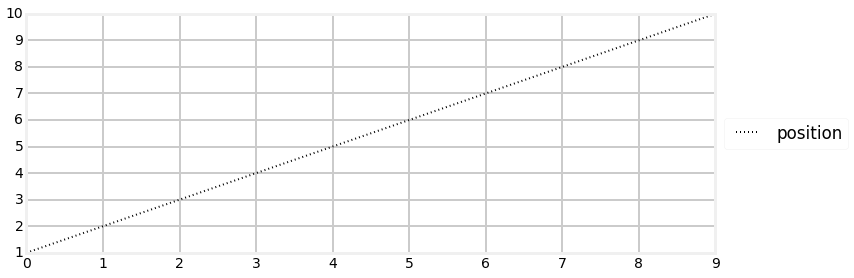

In [3]:
import matplotlib.pyplot as plt
import book_plots as bp
import numpy as np

dog = DogSimulation(measurement_var=0.0)
N = 10
xs = np.zeros(N)
for i in range(N):
    dog.move()
    xs[i] = dog.sense_position()
    print("%.1f" % xs[i], end=' '),
bp.plot_track(xs, label='position')
bp.show_legend();

The constructor initialized the dog at position 0 with a velocity of 1 m/s (move 1.0 m to the right). So we would expect to see an output of 1..10, and indeed that is what we see.

Now let's inject some noise in the signal.

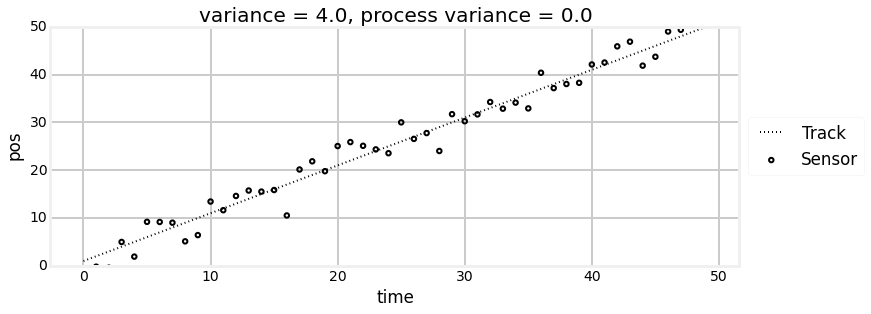

In [4]:
from  kf_internal import plot_dog_track
def test_sensor(measurement_var, process_var=0.0):
    dog = DogSimulation(0., 1., measurement_var, process_var)
    N = 50
    xs = np.zeros(N)
    for i in range(N):
        dog.move()
        xs[i] = dog.sense_position()
        
    plot_dog_track(xs, measurement_var, process_var)
test_sensor(measurement_var=4.0)

NumPy uses a random number generator to generate the normal distribution samples. The numbers I see as I write this are unlikely to be the ones that you see. If you run the cell above multiple times, you should get a slightly different result each time. I could use `numpy.random.seed(some_value)` to force the results to be the same each time. This would simplify my explanations in some cases, but would ruin the interactive nature of this chapter. To get a real feel for how normal distributions and Kalman filters work you will probably want to run cells several times, observing what changes, and what stays roughly the same.

The dotted line (labeled 'track') shows the actual position of the dog, and the circles (labeled 'sensor') depict the noisy signal produced by the simulated RFID sensor. Please note that the track was manually plotted - we do not yet have a filter that recovers that information from the sensor measurements! 

If you are running this in an interactive Jupyter Notebook, I strongly urge you to run the script several times in a row. You can do this by putting the cursor in the cell containing the Python code and pressing CTRL+Enter. Each time it runs you should see a different sensor output.

I also urge you to adjust the noise setting to see the result of various values. However, since you may be reading this in a static format I will show several examples. The first plot shows the noise set to 100.0, and the second shows noise set to 0.5.

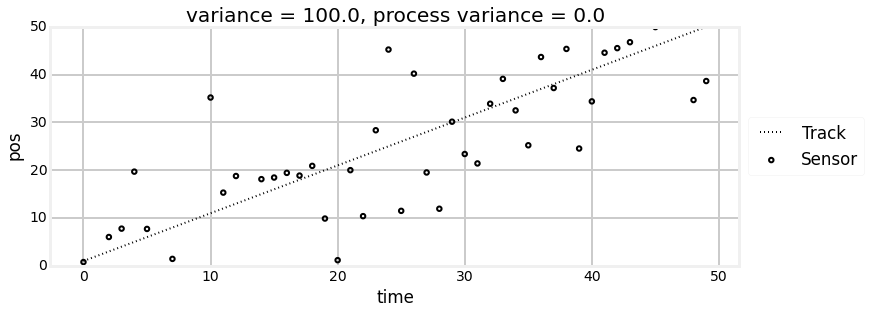

In [5]:
test_sensor(measurement_var=100.0)

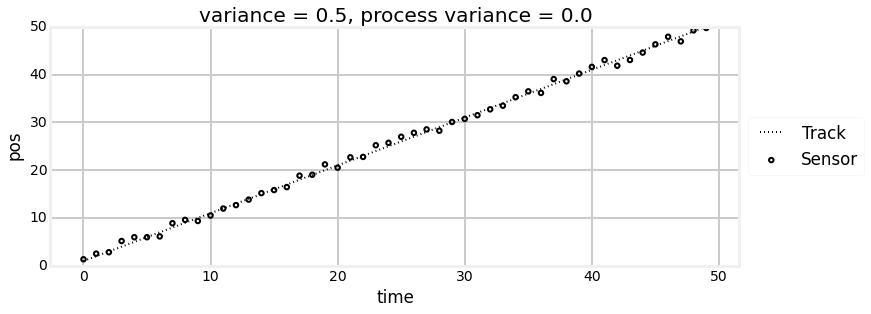

In [6]:
test_sensor(measurement_var=0.5)

Now lets see the effect of the process noise. My simulation is not meant to exactly model any given physical process. On each call to `sense_position()` I modify the current velocity by randomly generated normal process noise. However, I strive to keep the velocity close to the initial value, as I am assuming that there is a control mechanism in place trying to maintain the same speed. In this case, the control mechanism would be the dog's brain! For an automobile it could be a cruise control or the human driver.

So let's first look at the plot with some process noise but no measurement noise to obscure the results.

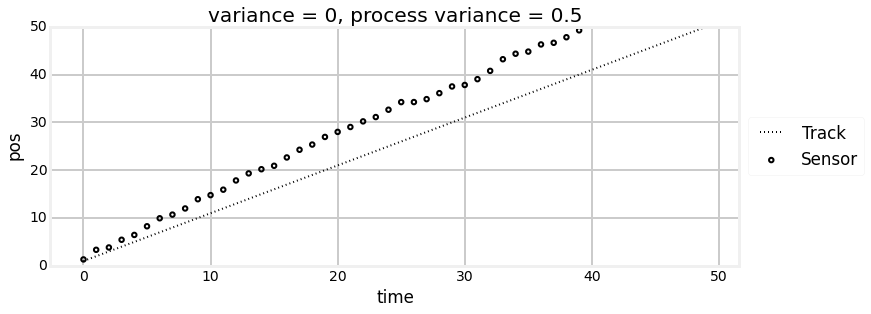

In [7]:
np.random.seed(1234) # this will make the dog wander away
test_sensor(measurement_var=0, process_var=0.5)

We can see that the position wanders from the ideal track. You may have thought that the track would have wandered back and forth the ideal path like the measurement noise did, but recall that we are modifying velocity on each, not the position. So once the track has deviated, it will remain deviated until the random changes in velocity happen to result in the track going back to the original track. 

Finally, let's look at the combination of measurement noise and process noise. Depending on the random number generation the sensor reading may lie on top of the track, or wander away from it. Try running it several times to observe the various possibilities. 

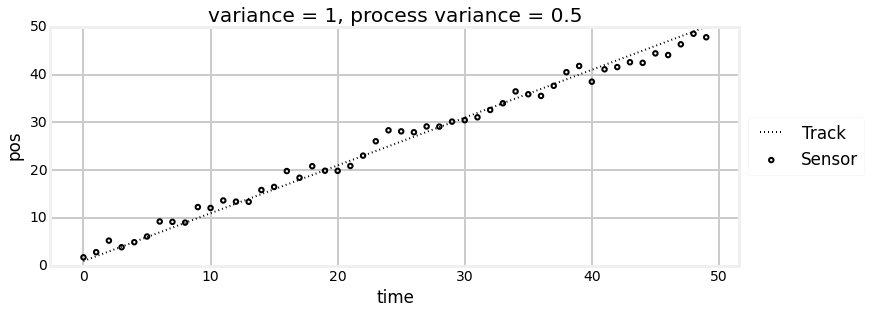

In [8]:
test_sensor(measurement_var=1, process_var=0.5)

## Math with Gaussians

We can express our belief in the dog's position with a Gaussian. Say we believe that our dog is at 23 meters, and the variance in that belief is 5 m$^2$, or $\mathcal{N}(23,\, 5)$. We can represent that in a plot:

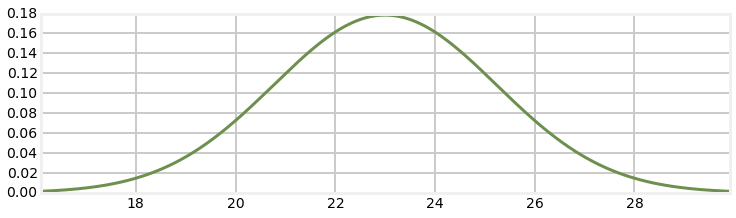

In [9]:
from book_format import set_figsize, figsize
import filterpy.stats as stats
with figsize(y=3):
    stats.plot_gaussian_pdf(mean=23, variance=5)

This chart depicts our belief, in other words our uncertainty about the dog's position. Notice how this relates to the bar charts from the Discrete Bayes chapter. In that chapter we drew bars of various heights to depict the probability that the dog was at any given position. In many cases those bars took on a shape very similar to this chart. The differences are that the bars depict the probability of a discrete position, whereas this chart depicts the probability distribution of a continuous range of positions. 

This graph corresponds to a fairly inexact belief. While we believe that the dog is at 23 m, note that roughly speaking positions 21 m to 25 m are quite likely as well. Let's assume for the moment our dog is standing still, and we query the sensor again. This time it returns 23.2 m as the position. Can we use this additional information to improve our estimate of the dog's position?

Intuition suggests we can. Consider: if we read the sensor 100 times and each time it returned a value between 21 and 25, all centered around 23, we should be very confident that the dog is near 23. Of course, a different physical interpretation is possible. Perhaps our dog was randomly wandering back and forth in a way that exactly emulated a normal distribution. But that seems extremely unlikely - I certainly have never seen a dog do that. So the only reasonable assumption is that the dog was mostly standing still at 23.0.

Let's look at 100 sensor readings in a plot, where we assume the dog stands still at 23 m.

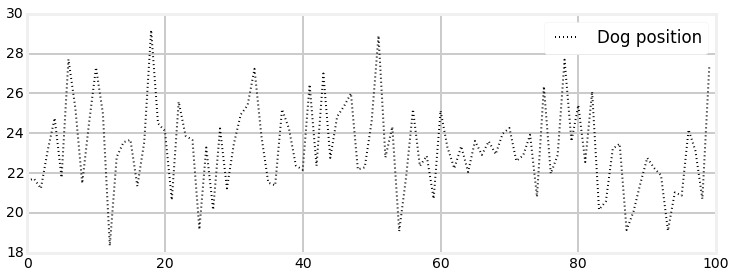

In [10]:
dog = DogSimulation(23, 0, measurement_var=5, process_var=0.0)
xs = range(100)
ys = []
for _ in xs:
    dog.move()
    ys.append(dog.sense_position())               
bp.plot_track(xs, ys, label='Dog position')
plt.legend(loc='best');

Eyeballing this confirms our intuition - no dog moves like this. However, noisy sensor data certainly looks like this. So let's proceed and try to solve this mathematically. But how?


Recall the code for adding a measurement to a preexisting belief from the **Discrete Bayes** chapter:

```python
def update(pos, measure, p_hit, p_miss):
    q = array(pos, dtype=float)
    for i in range(len(hallway)):
        if hallway[i] == measure:
            q[i] = pos[i] * p_hit
        else:
            q[i] = pos[i] * p_miss
     normalize(q)
     return q
```
         
The algorithm is computing:

```python
new_belief = prior_belief * measurement * sensor_error
```
    
The `measurement * sensor_error` term might not be obvious, but recall that measurement in this case was always 1 or 0, and so it was left out for convenience. Here *prior* carries the both the colloquial sense of *previous*, but also the Bayesian meaning. In Bayesian terms the *prior* is the probability after the prediction and before the measurements have been incorporated.
    
If we are implementing this with Gaussians, we might expect it to be implemented as:

```python
new_gaussian = measurement * old_gaussian
```
    
where measurement is a Gaussian returned from the sensor. But does that make sense? Can we multiply Gaussians? If we multiply a Gaussian with a Gaussian is the result another Gaussian, or something else?

The algebra for this is not extremely hard, but it is messy. It uses Bayes theorem to compute the posterior (new Gaussian) given the prior (old Gaussian) and the likelihood (the probability for the measurement). I've placed the math at the bottom of the chapter if you are interested in the details. Here I will present the results. The subscript $\mathtt{z}$ stands for the *measurement*.
$$\begin{aligned}
\mathcal{N}(\mu_\mathtt{posterior}, \sigma_\mathtt{posterior}^2) &= \mathcal{N}(\mu_\mathtt{prior}, \sigma_\mathtt{prior}^2)\times \mathcal{N}(\mu_\mathtt{z}, \sigma_\mathtt{z}^2) \\
&= \mathcal{N}(\frac{\sigma_\mathtt{prior}^2 \mu_\mathtt{z} + \sigma_\mathtt{z}^2 \mu_\mathtt{prior}}{\sigma_\mathtt{prior}^2 + \sigma_\mathtt{z}^2},\frac{1}{\frac{1}{\sigma_\mathtt{prior}^2} + \frac{1}{\sigma_\mathtt{z}^2}})
\end{aligned}$$ 

In other words the result of multiplying two Gaussians is a Gaussian is 

$$\begin{aligned}
\mu &=\frac{\sigma_\mathtt{prior}^2 \mu_z + \sigma_\mathtt{z}^2 \mu_\mathtt{prior}} {\sigma_\mathtt{prior}^2 + \sigma_\mathtt{z}^2}, \\
\sigma^2 &= \frac{1}{\frac{1}{\sigma_\mathtt{prior}^2} + \frac{1}{\sigma_\mathtt{z}^2}} =
\frac{\sigma_\mathtt{prior}^2\sigma_\mathtt{z}^2}{\sigma_\mathtt{prior}^2+\sigma_\mathtt{z}^2}
\end{aligned}$$

Without doing a deep analysis we can immediately infer some things. First and most importantly the result of multiplying two Gaussians is another Gaussian. The mean is a scaled sum of the prior and the measurement. The variance is a combination of the variances of the variances of the input. We conclude from this that the variances are completely unaffected by the values of the mean!

Let's examine the result of multiplying $\mathcal{N}(23,\, 5)$ with itself. This corresponds to getting 23.0 as the sensor value twice in a row. But before you look at the result, what do you think the result will look like? What should the new mean be? Will the variance be wider, narrower, or the same?

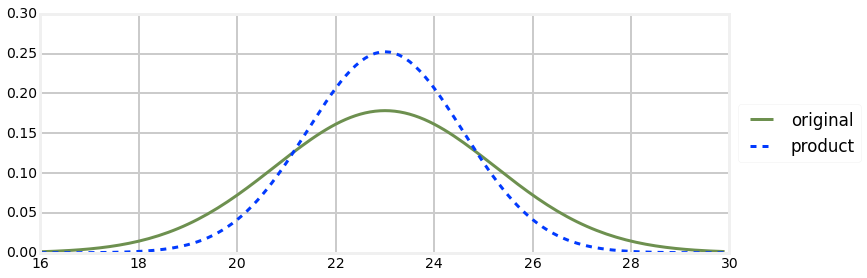

In [11]:
import filterpy.stats as stats

def multiply(mu1, var1, mu2, var2):
    # avoid division by zero
    if var1 == 0.0: var1 = 1.e-80
    if var2 == 0.0: var2 = 1.e-80

    mean = (var1*mu2 + var2*mu1) / (var1 + var2)
    variance = 1 / (1/var1 + 1/var2)
    return (mean, variance)

xs = np.arange(16, 30, 0.1)

mean1, var1 = 23, 5
mean, var = multiply(mean1, var1, mean1, var1)

ys = [stats.gaussian(x, mean1, var1) for x in xs]
plt.plot(xs, ys, label='original')

ys = [stats.gaussian(x, mean, var) for x in xs]
plt.plot(xs, ys, label='product', ls='--')
bp.show_legend();

The result of the multiplication is taller and narrow than the original Gaussian but the mean is the same. Does this match your intuition of what the result should have been?

If we think of the Gaussians as two measurements, this makes sense. If I measure twice and get 23 meters each time, I should conclude that the length is close to 23 meters. Thus the mean should be 23. I am more confident with two measurements than with one, so the variance of the result should be smaller. 

"Measure twice, cut once" is a useful saying and practice due to this fact!  The Gaussian is a mathematical model of this physical fact, so we should expect the math to follow our physical process. 

Now let's multiply two Gaussians (or equivalently, two measurements) that are partially separated. In other words, their means will be different, but their variances will be the same. What do you think the result will be? Think about it, and then look at the graph.

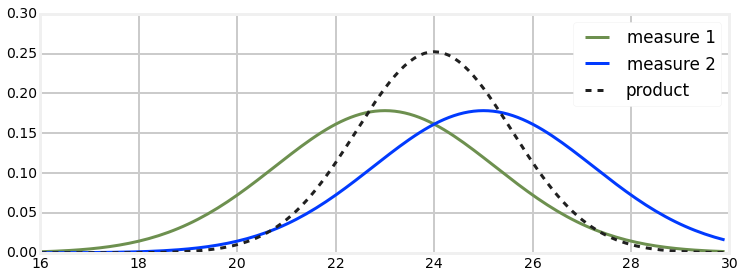

In [12]:
xs = np.arange(16, 30, 0.1)

mean1, var1 = 23, 5
mean2, var2 = 25, 5
mean, var = multiply(mean1, var1, mean2, var2)

ys = [stats.gaussian(x, mean1, var1) for x in xs]
plt.plot(xs, ys, label='measure 1')

ys = [stats.gaussian(x, mean2, var2) for x in xs]
plt.plot(xs, ys, label='measure 2')

ys = [stats.gaussian(x, mean, var) for x in xs]
plt.plot(xs, ys, label='product', ls='--')
plt.legend();

Another beautiful result! If I handed you a measuring tape and asked you to measure the distance from table to a wall, and you got 23 meters, and then a friend make the same measurement and got 25 meters, your best guess must be 24 meters if you trust the skills of your friends equally.

That is fairly counter-intuitive in more complicated situations, so let's consider it further. Perhaps a more reasonable assumption would be that either you or your coworker made a mistake, and the true distance is either 23 or 25, but certainly not 24. Surely that is possible. However, suppose the two measurements you reported as 24.01 and 23.99. In that case you would agree that in this case the best guess for the correct value is 24?  Which interpretation we choose depends on the properties of the sensors we are using.

This topic is fairly deep, and I will explore it once we have completed our Kalman filter. For now I will merely say that the Kalman filter requires the interpretation that measurements are accurate, with Gaussian noise, and that a large error caused by misreading a measuring tape is not Gaussian noise.

Dealing with incorrect measurements, such as measuring the distance to the wrong object, is a topic we will need to treat separately. The filter assumes that the data you feed it is correct, just noisy. Engineers that design radar systems probably spend much of their effort on the problem of incorrect measurements; it is a deep and difficult topic which we will ignore for now.

One final test of your intuition. What if the two measurements are widely separated? 

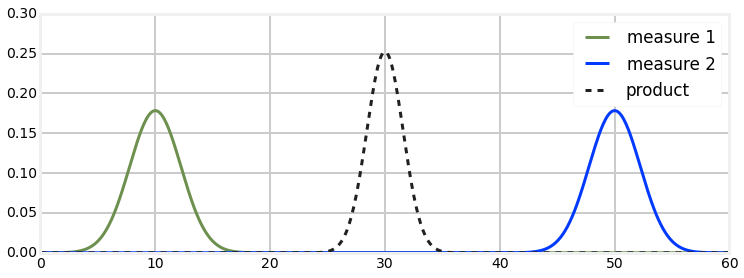

In [13]:
xs = np.arange(0, 60, 0.1)

mean1, var1 = 10, 5
mean2, var2 = 50, 5
mean, var = multiply(mean1, var1, mean2, var2)

ys = [stats.gaussian(x, mean1, var1) for x in xs]
plt.plot(xs, ys, label='measure 1')

ys = [stats.gaussian(x, mean2, var2) for x in xs]
plt.plot(xs, ys, label='measure 2')

ys = [stats.gaussian(x, mean, var) for x in xs]
plt.plot(xs, ys, label='product', ls='--')
plt.legend();

This result bothered me quite a bit when I first learned it. If my first measurement was 10, and the next one was 50, why would I choose 30 as a result? And why would I be *more* confident? Doesn't it make sense that either one of the measurements is wrong, or that I am measuring a moving object? Shouldn't the result be nearer 50? And, shouldn't the variance be larger, not smaller?

Well, no. Recall the g-h filter chapter. We agreed that if I weighed myself on two scales, and the first read 160 lbs while the second read 170 lbs, and both were equally accurate, the best estimate was 165 lbs. Furthermore I should be a bit more confident about 165 lbs vs 160 lbs or 170 lbs because I know have two readings, both near this estimate, increasing my confidence that neither is wildly wrong. 

Of course, this example is quite exaggerated. The width of the Gaussians is fairly narrow, so this combination of measurements is extraordinarily unlikely. It is hard to eyeball this, but the measurements are well over $3\sigma$ apart, so the probability of this happening is much less than 1%. Still, it can happen, and the math is correct. 

Let's look at the math again to convince ourselves that the physical interpretation of the Gaussian equations makes sense. I'm going to switch back to using priors and measurements. The math and reasoning is the same whether you are using a prior and incorporating a measurement, or just trying to compute the mean and variance of two measurements. For Kalman filters we will be doing a lot more of the former than the latter, so let's get used to it.

$$
\mu=\frac{\sigma_\mathtt{prior}^2\, \mu_\mathtt{z} + \sigma_\mathtt{z}^2 \, \mu_\mathtt{prior}} {\sigma_\mathtt{prior}^2 + \sigma_\mathtt{z}^2}
$$

If both have the same accuracy, then $\sigma_\mathtt{prior}^2 = \sigma_\mathtt{z}^2$, and the resulting equation is

$$\mu=\frac{\sigma_\mathtt{z}^2\,  (\mu_\mathtt{prior} + \mu_\mathtt{z})}{2\sigma_\mathtt{z}^2}\\
= \frac{1}{2}(\mu_\mathtt{prior} + \mu_\mathtt{z})$$

which is the average of the two means. If we look at the extreme cases, assume the first scale is very much more accurate than than the second one. At the limit, we can set 
$\sigma_\mathtt{prior}^2=0$, yielding

$$
\begin{aligned}
\mu&=\frac{0*\mu_\mathtt{z} + \sigma_\mathtt{z}^2 \mu_\mathtt{prior}} { \sigma_\mathtt{z}^2}, \\
\text{or}\\
\mu&=\mu_\mathtt{prior}
\end{aligned}
$$

Finally, if we set $\sigma_\mathtt{prior}^2 = 9\sigma_\mathtt{z}^2$, then the resulting equation is

$$
\begin{aligned}
\mu&=\frac{9 \sigma_\mathtt{z}^2 \mu_\mathtt{z} + \sigma_\mathtt{z}^2\, \mu_\mathtt{prior}} {9 \sigma_\mathtt{z}^2 + \sigma_\mathtt{z}^2} \\
\text{or}\\
\mu&= \frac{1}{10} \mu_\mathtt{prior} + \frac{9}{10} \mu_\mathtt{z}
\end{aligned}
$$

This again fits our physical intuition of favoring the second, accurate scale over the first, inaccurate scale.

### Interactive Example

Rather than going through a dozen examples, lets use interactive code. Here you can use sliders to alter the mean and variance of two Gaussians. As you change the values a plot of the two Gaussians along with the product of the two is displayed.

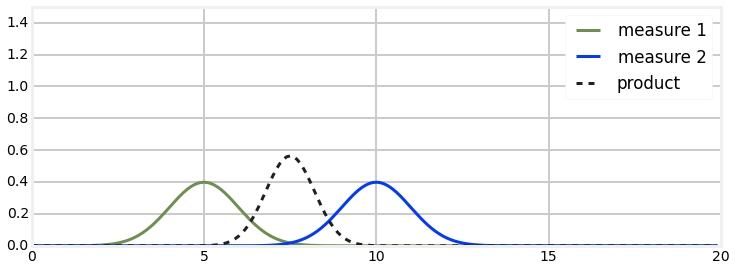

In [14]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html.widgets import FloatSlider

def plot_products(mu_1, mu_2, var_1, var_2):
    xs = np.arange(0, 20, min(var_1, var_2)/10)
    ys = [stats.gaussian(x, mu_1, var_1) for x in xs]
    plt.plot(xs, ys, label='measure 1')

    ys = [stats.gaussian(x, mu_2, var_2) for x in xs]
    plt.plot(xs, ys, label='measure 2')

    mean, var = multiply(mu_1, var_1, mu_2, var_2)
    ys = [stats.gaussian(x, mean, var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    plt.ylim(0, 1.5)
    plt.legend();
    
interact(plot_products,
         mu_1=FloatSlider(value=5, min=0., max=15), 
         mu_2=FloatSlider(value=10, min=0., max=15), 
         var_1=FloatSlider(value=1, min=.1, max=5.), 
         var_2=FloatSlider(value=1, min=.1, max=5.));

## Implementing the Update Step

The discrete Bayes filter uses a NumPy array to encode our belief about the position of our dog at any time. That array stored our belief of our dog's position in the hallway using 10 discrete positions. This was very crude, because with a 100 meter hallway that corresponded to positions 10 meters apart. It would have been trivial to expand the number of positions to say 1,000, and that is what we would do if using it for a real problem. But the problem remains that the distribution is discrete and multimodal - it can express strong belief that the dog is in two positions at the same time.

In this chapter we use a Gaussian to reflect our belief of the dog's position. In other words, we will use $\mathtt{pos}_{\mathtt{dog}} = \mathcal{N}(\mu,\, \sigma^2)$. Gaussians extend to infinity on both sides of the mean, so the single Gaussian will cover the entire hallway. They are unimodal, and seem to reflect the behavior of real-world sensors - most errors are small and clustered around the mean. Here is the entire implementation of the update function for a Kalman filter:

In [15]:
def update(mean, var, measurement, measurement_var):
    return multiply(mean, var, measurement, measurement_var)

Kalman filters are supposed to be hard! But this is very short and straightforward. All we are doing is multiplying the Gaussian that reflects our belief of where the dog is with the new measurement.

Perhaps this would be clearer if we used more specific names:

```python
def update_dog(dog_pos, dog_var, measurement, measurement_var):
    return multiply(dog_pos, dog_var, 
                    measurement, measurement_var)
```

That is less abstract, which perhaps helps with comprehension, but it is poor coding practice. We are writing a Kalman filter that works for any problem, not just tracking dogs in a hallway, so we won't use variable names with 'dog' in them. Still, the `update_dog()` function should make what we are doing very clear. 

Let's look at an example. We will suppose that our current belief for the dog's position is $\mathcal{N}(2,\, 5)$. Don't worry about where that number came from as I'll answer that shortly. We will create a `DogSimulation` object initialized to be at position 0.0 with no velocity, and modest noise. This corresponds to the dog standing still at the far left side of the hallway. Note that the belief $\mathcal{N}(2,\, 5)$ means that we mistakenly believe the dog is at position 2.0, not 0.0.

In [16]:
dog = DogSimulation(velocity=0., measurement_var=5, process_var=0.0)
pos, var = 2, 5
for i in range(20):
    dog.move()
    pos, var = update(pos, var, dog.sense_position(), 5)
    print('time:', "%2d" % i, 
          '\tposition:', "%.3f" % pos, 
          '\tvariance:', "%.3f" % var)

time:  0 	position: -0.033 	variance: 2.500
time:  1 	position: -0.969 	variance: 1.667
time:  2 	position: -0.985 	variance: 1.250
time:  3 	position: -0.167 	variance: 1.000
time:  4 	position: 0.024 	variance: 0.833
time:  5 	position: 0.419 	variance: 0.714
time:  6 	position: 0.190 	variance: 0.625
time:  7 	position: 0.109 	variance: 0.556
time:  8 	position: 0.177 	variance: 0.500
time:  9 	position: -0.024 	variance: 0.455
time: 10 	position: -0.042 	variance: 0.417
time: 11 	position: 0.002 	variance: 0.385
time: 12 	position: -0.048 	variance: 0.357
time: 13 	position: -0.054 	variance: 0.333
time: 14 	position: -0.002 	variance: 0.312
time: 15 	position: -0.042 	variance: 0.294
time: 16 	position: -0.195 	variance: 0.278
time: 17 	position: -0.001 	variance: 0.263
time: 18 	position: -0.020 	variance: 0.250
time: 19 	position: -0.077 	variance: 0.238


Because of the random numbers I do not know the exact values that you see, but the position should have converged to near 0 m despite the initial error of believing that the position was 2.0 m. Furthermore, the variance should have converged from the initial value of 5.0 to 0.238.

By now the fact that we converged to a position of 0.0 should not be terribly surprising. All we are doing is computing `new_pos = old_pos * measurement` and the measurement is a normal distribution around 0, so we should get very close to 0 after 20 iterations. But the truly amazing part of this code is how the variance became 0.238 despite every measurement having a variance of 5.0. 

If we think about the physical interpretation of this is should be clear that this is what should happen. If you sent 20 people into the hall with a tape measure to physically measure the position of the dog you would be very confident in the result after 20 measurements - more confident than after 1 or 2 measurements. So it makes sense that as we make more measurements the variance gets smaller.

Mathematically it makes sense as well. Recall the computation for the variance after the multiplication: $\sigma^2 = 1/(\frac{1}{{\sigma}_1^2} + \frac{1}{{\sigma}_2^2})$. We take the reciprocals of the sigma from the measurement and prior belief, add them, and take the reciprocal of the result. Think about that for a moment, and you will see that this will always result in smaller numbers as we proceed.

## Implementing Predictions

That is a beautiful result, but it is not yet a filter. We assumed that the dog was sitting still, an extremely dubious assumption. The discrete Bayes filter used a loop of predict and update functions, and we must do the same to accommodate movement.

How do we perform the predict function with Gaussians? Recall the discrete Bayes method:

```python
def predict(pos, move, p_correct, p_under, p_over):
    n = len(pos)
    result = array(pos, dtype=float)
    for i in range(n):
            result[i] =  \
            pos[(i-move) % n]   * p_correct + \
            pos[(i-move-1) % n] * p_over + \
            pos[(i-move+1) % n] * p_under          
    return result
```

In a nutshell, we shift the probability array by the amount we believe the dog moved, and adjust the probability. How do we do that with Gaussians?

It turns out that we add them. Think of the case without Gaussians. I think my dog is at 7.3 meters, and he moves 2.6 meters to right, where is he now? Obviously, 7.3 + 2.6 = 9.9. He is at 9.9 meters. The algorithm is `new_pos = old_pos + dist_moved`. It does not matter if we use floating point numbers or Gaussians for these values, the algorithm must be the same. 

How is addition for Gaussians performed? It turns out to be very simple:

$$ \mathcal{N}(\mu_1, \sigma_1^2)+\mathcal{N}(\mu_2, \sigma_2^2) = \mathcal{N}(\mu_1 +\mu_2, \sigma_1^2 + \sigma_2^2)$$

In other words

$$\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
$$

We can make this more meaningful by changing the subscripts.

$$\begin{aligned}
\mu_\mathtt{after} &= \mu_\mathtt{before} + \mu_\mathtt{movement} \\
\sigma^2_\mathtt{after} &= \sigma^2_\mathtt{before}+ \sigma^2_\mathtt{movement}
\end{aligned}$$

All we do is add the means and the variance separately! Does that make sense? Think of the physical representation of this abstract equation.
${\mu}_\mathtt{before}$ is the old position, and ${\mu}_\mathtt{movement}$ is how far we moved. Surely it makes sense that our new position is $\mu_\mathtt{before} + \mu_\mathtt{movement}$.

What about the variance? It is perhaps harder to form an intuition about this. However, recall that with the `predict()` function for the discrete Bayes filter we always lost information - our confidence after the update was lower than our confidence before the update. We don't really know where the dog is moving, so the confidence should get smaller (variance gets larger). $\sigma^2_\mathtt{movement}$ is the amount of uncertainty added to the system due to the imperfect prediction about the movement, and so we would add that to the existing uncertainty. 

I assure you that the equation for Gaussian addition is correct, and derived by basic algebra. Therefore it is reasonable to expect that if we are using Gaussians to model physical events, the results must correctly describe those events.

Now is a good time to either work through the algebra to convince yourself of the mathematical correctness of the algorithm, or to work through some examples and see that it behaves reasonably. This book will do the latter.

So, here is our implementation of the predict function:

In [17]:
def predict(pos, variance, movement, movement_variance):
    return (pos + movement, variance + movement_variance)

What is left? Just calling these functions. Discrete Bayes did nothing more than loop over the `update()` and `predict()` functions, so let's do the same. 

PREDICT:     x      var	  UPDATE:   x      var       z
           1.000  401.000	  1.352   1.990	   1.354
           2.352    2.990	  2.070   1.198	   1.882
           3.070    2.198	  3.736   1.047	   4.341
           4.736    2.047	  5.960   1.012	   7.156
           6.960    2.012	  6.949   1.003	   6.939
           7.949    2.003	  7.396   1.001	   6.844
           8.396    2.001	  9.122   1.000	   9.847
          10.122    2.000	 11.338   1.000	   12.553
          12.338    2.000	 14.305   1.000	   16.273
          15.305    2.000	 15.053   1.000	   14.800

final estimate:            15.053
actual final position:     14.838


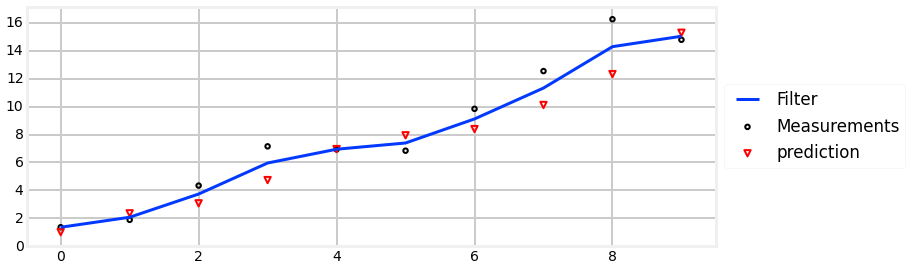

In [18]:
import kf_internal

np.random.seed(13)
pos = (0., 400.)   # Gaussian N(0, 400)
velocity = 1.

# variance in process model and the RFID sensor
process_var = 1.
sensor_var = 2.

dog = DogSimulation(pos[0], velocity, sensor_var, process_var)

# simulate dog and get measurements
N = 10
zs = [dog.move_and_sense() for _ in range(N)]

positions, predictions = [], []
print('PREDICT:     x      var\t  UPDATE:   x      var       z')
for i, z in enumerate(zs):
    pred_pos = predict(pos[0], pos[1], velocity, process_var)
    predictions.append(pred_pos[0])

    pos = update(pred_pos[0], pred_pos[1], z, sensor_var)
    positions.append(pos[0])
    
    kf_internal.print_gh(pred_pos, pos, z)
print()
print('final estimate:        {:10.3f}'.format(pos[0]))
print('actual final position: {:10.3f}'.format(dog.x))
bp.plot_filter(positions)
bp.plot_measurements(zs)
bp.plot_predictions(predictions)
bp.show_legend();

Before we discuss the code and results, let's try to understand this better with this chart showing one predict update cyle.

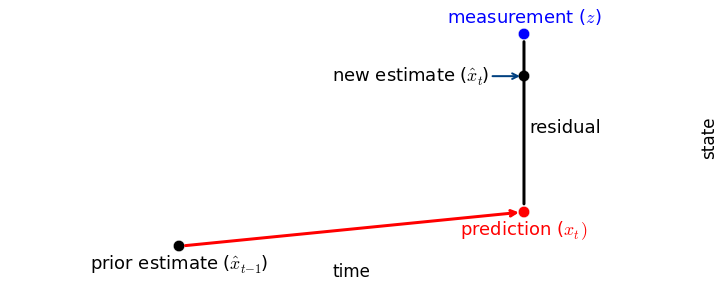

In [19]:
from mkf_internal import show_residual_chart
show_residual_chart()

This chart is very similar to one we already saw in the *g-h Filter* chapter. At each predict step we take our existing estimate and update it based on our process model. We then make a measurement. The difference between the measurement and the prediction is called the *residual*. We know neither the measurement or prediction is perfect, so we choose a value in between the two. This is scaled so that the new estimate is closer to the one we trust more. That scaling depends on the variance of the measurement vs the variance of the process model. We then step time forward one step, and what was the new estimate is considered to be the prior estimate, and the process repeats. 

Now let's walk through the code and output.

```python
pos = (0., 400.) # Gaussian N(0, 400)
```
    
Here we set the initial position at 0 m. We set the variance to 400 m$^2$, which is a standard deviation of 20 meters. You can think of this as saying "I believe with 99% accuracy the position is 0 plus or minus 60 meters". This is because with Gaussians ~99% of values fall within 3$\sigma$ of the mean.

```python
velocity = 1.
```
    
So how do I know the velocity? Magic? Consider it a prediction, or perhaps we have a secondary velocity sensor. If this is a robot then this would be a control input to the robot. In subsequent chapters we will learn how to handle situations where you don't have a velocity sensor or input, so please accept this simplification for now.

```python
process_var = 1.
sensor_var = 2.
```
   
Here the variance for the predict step is `process_var` and the variance for the sensor is `sensor_var`. The meaning of sensor variance should be clear - it is how much variance there is in each sensor reading. The process variance is how much error there is in the prediction model. We are predicting that at each time step the dog moves forward one meter. Dogs rarely do what we expect, and of course things like hills or the whiff of a squirrel will change his progress. If this was a robot responding to digital commands the performance would be better, but not perfect. Perhaps a hand made robot would have a variance of $\sigma^2=.1$, and an industrial robot might have $\sigma^2=0.02$. These are not 'magic' numbers; the square root of the express the distance error in meters. It is easy to get a Kalman filter working by just plugging in numbers, but if the numbers do not reflect reality the performance of the filter will be poor.

Next we initialize the simulator and run it with

```python
dog = DogSimulation(pos[0], velocity, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
```
    
It may seem very 'convenient' to set the simulator to the same position as our guess, and it is. Do not fret. In the next example we will see the effect of a wildly inaccurate guess for the dog's initial position. We move the dog for 10 steps forward and store the measurements in `zs` via a list comprehension.

It is traditional to label the measurement $z$, and so I follow that convention here. When I was learning this topic I found the standard variable names very obscure. However, if you wish to read the literature you will have to become used to them, so I will not use a more readable variable name such as `m` or `measure`. It is something you have to memorize if you want to work with Kalman filters. As we continue I will introduce more of the standard naming into the code. The `s` at the end of the name is a plural - I'm saying there are many `z`s in the list. This is a common convention with mathematical Python code.

The next line allocates an array to store the output of the filtered positions. 

```python
positions =  np.zeros(N)
```

Now we enter our `predict() ... update()` loop.

```python
for i in range(N):
    pred_pos = predict(pos[0], pos[1], vel, process_var)
    pos = update(pred_pos[0], pred_pos[1], z, sensor_var)
    positions.append(pos[0])
```

We call the `predict()` function with the Gaussian for the dog's position, and another Gaussian for its movement. `pos[0], pos[1]` is the mean and variance for the position, and 'vel, process_var' is the mean and variance for the movement. 

The first time through the loop I get `pred_pos = (1.0, 401.0)`, as can be seen in the printed table.

What is this saying? After the prediction, we believe that we are at 1.0, and the variance is now 401. Recall we started at 400. The variance got worse, which is always what happens during the prediction step because it involves a loss of information.

Then we call the update function of our filter, using `pred_pos` as the current position and save the result in our `positions` array.

For this I get this as the result: `pos = (1.352, 1.990), z = 1.354`.

What is happening? The dog is actually at 1.0 but the measured position is 1.354 due to the sensor noise. That is pretty far off from the predicted value of 1. The filter incorporates that measurement into its prediction. This is the first time through the loop and so the variance is 401 m$^2$. A large variance implies that the current prediction is very poor, so the filter estimates the position to be 1.352 - very close to the measurement. Intuition tells us that the results should get better as we make more measurements, so let's hope that this is true for our filter as well.

Now look at the variance: 1.99 m$^2$. It has dropped tremendously from 401 m$^2$. Why? Well, the RFID has a reasonably small variance of 2.0 m$^2$, so we trust it far more than our previous belief. However, the previous belief does contain a bit of useful information, so our variance is now slightly smaller than 2.0, which is the variance of the measurement alone.

Now the software loops, calling `predict()` and `update()` in turn. By the end the final estimated position is 15.053 vs the actual position of 14.838. The variance has converged to 1.0 m$^2$. 

Now look at the plot. The noisy measurements are plotted in with a dotted red line, and the filter results are in the solid blue line. Both are quite noisy, but notice how much noisier the measurements (red line) are. This is your first Kalman filter and it seems to work!

Before we continue I want to point out how few lines of code actually perform the filtering. Most of the code is either initialization, storing of data, simulating the dog movement, and printing results. The code that performs the filtering is the very succinct. 

```python
for i in range(N):
    pos = predict(pos[0], pos[1], vel, process_var)
    pos = update(pos[0], pos[1], z, sensor_var)
```
If we didn't use pre-written functions the the code would be:

```python
    for i in range(N):
        # predict
        pos = pos + vel
        var = var + sensor_var

        # update
        pos  = (var*vel + process_var*pos) / (var + process_var)
        var = 1 / (1/var + 1/process_var)
```    

Just 4 lines of very simple math implements the entire filter!

In this example I only plotted 10 data points so the output from the print statements would not overwhelm us. Now let's look at the filter's performance with more data. This time we will plot both the output of the filter and the variance. The variance is plotted as a lightly shaded yellow area between dotted lines. I've increased the size of the process and sensor variance so they are easier to see on the chart - for a real Kalman filter of course you will not be randomly changing these values.

Variance:
	4.4502 2.6507 2.2871 2.1955 2.1712
	2.1647 2.1629 2.1625 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623


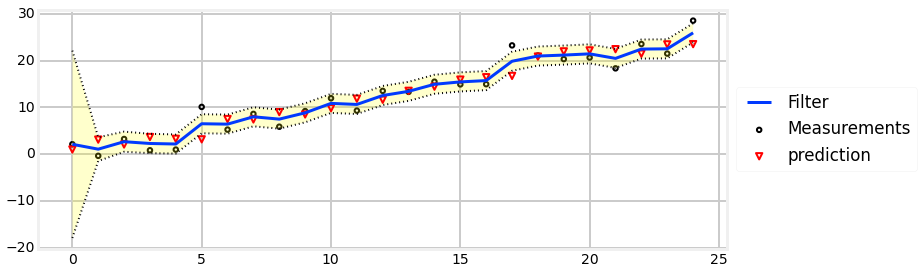

In [20]:
process_var = 2
sensor_var = 4.5
pos = (0, 400)   # gaussian N(0, 400)
N = 25

dog = DogSimulation(pos[0], velocity, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

positions, predictions = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    pos = predict(pos[0], pos[1], velocity, process_var)    
    predictions[i] = pos
    
    pos = update(pos[0], pos[1], z, sensor_var)
    positions[i] = pos

bp.plot_measurements(zs)
bp.plot_filter(positions[:, 0], var=predictions[:, 1])
bp.plot_predictions(predictions[:, 0])
bp.show_legend()
kf_internal.print_variance(positions)

Here we can see that the variance converges very quickly to roughly 2.1623 in 10 steps. We interpret this as meaning that we become very confident in our position estimate very quickly. The first few measurements are unsure due to our uncertainty in our guess at the initial position, but the filter is able to quickly determine an accurate estimate.

> Before I go on, I want to emphasize that this code fully implements a one dimensional Kalman filter. "One dimensional" just refers to the fact we are tracking one variable. If you have tried to read the literature you are perhaps surprised, because this looks nothing like the endless pages of math in those books. To be fair, the math gets more complicated in multiple dimensions, but not by much. So long as we worry about *using* the equations rather than *deriving* them we can create Kalman filters without a lot of effort. Moreover, I hope you'll agree that you have a decent intuitive grasp of what is happening. We represent our beliefs with Gaussians, and our beliefs get better over time because more measurements means we have more data to work with.

### Exercise: Modify Variance Values

Modify the values of `process_var` and `sensor_var` and note the effect on the filter and on the variance. Which has a larger effect on the variance convergence?. For example, which results in a smaller variance:

```python
process_var = 40
sensor_var = 2
```
    
or:

```python
process_var = 2
sensor_var = 40
```

### Tracking Animation

If you are reading this in a browser you will be able to see an animation of the filter tracking the dog directly below this sentence.
<img src='animations/05_dog_track.gif'>

The top plot shows the output of the filter in green, and the measurements with a dashed red line. The bottom plot shows the Gaussian at each step. 

When the track first starts you can see that the measurements varies quite a bit from the initial prediction. At this point the Gaussian probability is small (the curve is low and wide) so the filter does not trust its prediction. As a result, the filter adjusts its estimate a large amount. As the filter innovates you can see that as the Gaussian becomes taller, indicating greater certainty in the estimate, the filter's output becomes very close to a straight line. At `x=15` and greater you can see that there is a large amount of noise in the measurement, but the filter does not react much to it compared to how much it changed for the firs noisy measurement.

## The Kalman Filter is a g-h Filter


Earlier we set $\sigma_\mathtt{prior}^2 = 9\sigma_\mathtt{z}^2$, to get

$$\mu= \frac{1}{10} \mu_\mathtt{prior} + \frac{9}{10} \mu_\mathtt{z}$$

We can see that we are scaling the prior and the measurement by some factor. Think back to the **g-h Filter** chapter and this plot:

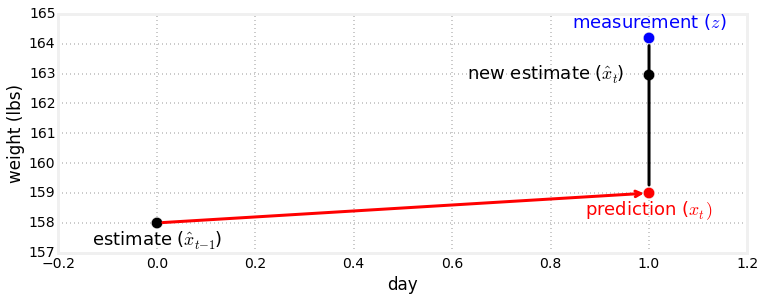

In [21]:
import gh_internal
gh_internal.plot_estimate_chart_3()

The Kalman filter equation is performing this computation! We have a measurement and a prediction, and the new estimate is chosen as some value between the two. So, as promised, the Kalman filter is a g-h filter. 

I have not made it explicit in this chapter, but the scaling factor is called the **Kalman gain**. In this equation

$$\mu= \frac{1}{10} \mu_\mathtt{prior} + \frac{9}{10} \mu_\mathtt{z}$$

if set the Kalman gain $K = 0.9$ we can rewrite the equation as

$$\mu = (1-K)\mu_\mathtt{prior} + K\mu_\mathtt{z}$$

That is a general equation for the Kalman filter in the one dimensional case. 

How does this relate to the g-h filter? In the g-h filter we chose the constants $g$ and $h$ and didn't vary them. Here the scaling factors are chosen dynamically based on the current variance of the filter and the variance of the measurement. in other words the Kalman gain is determined by a ratio of the variances of the prior and measurement. As the Kalman filter innovates the scaling factors change as we become more (or less) certain about our answer.

Some algebra will reveal the relationship between the Kalman filter and the g-h filter. If you are curious, I present it in **Kalman Filter Math** chapter.

At each time step we can show that $g$ equals

$$g = \frac{\sigma^2_\mathtt{prior}}{\sigma^2_\mathtt{z}}$$

This make intuitive sense. When we perform an update we choose a value somewhere between the measurement and prediction. If the measurement is more accurate we will choose a value nearer it, and vice versa. This computation for $g$ is a ratio of the errors in the prediction and the measurement.

The equation for $h$ is similar.

$$h = \frac{COV (x,\dot{x})}{\sigma^2_\mathtt{z}}$$

We haven't discussed *covariance* (denoted by $COV$), so you may not fully understand this equation. Think of the numerator as the variance between the position and its velocity. Recall that $g$ is used to scale the state, and $h$ is used to scale the velocity of the state, and this equation should seem reasonable. In the next chapter it will become very clear.

The takeaway point is that $g$ and $h$ are specified fully by the variance and covariances of the measurement and predictions at time $n$. That is all the Kalman filter is. The Kalman filter is a g-h filter where $g$ and $h$ vary over time according to the variance of the measurements and our current beliefs.

## Full Description of the Algorithm

Recall the diagram we used for the g-h filter:

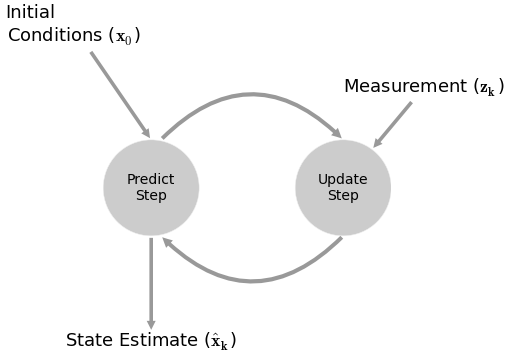

In [22]:
import gh_internal
gh_internal.create_predict_update_chart()

We've been doing the same thing in this chapter. And, as already mentioned, each filter makes a prediction, takes a measurement, and then forms a new estimate somewhere between the two.

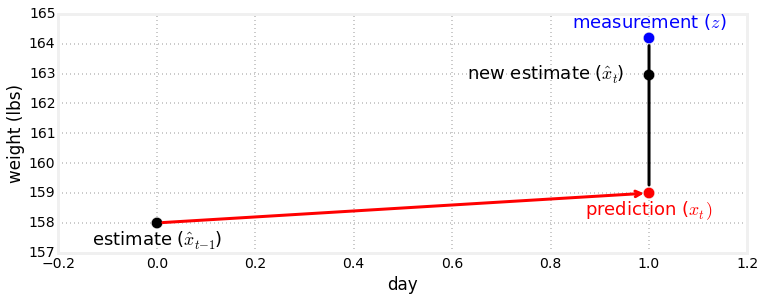

In [23]:
gh_internal.plot_estimate_chart_3()

**This is extremely important to understand**: Every filter in this book implements the **same algorithm**, just with different mathematical details. The math can become challenging in later chapters, but the idea is easy to understand.

It is important to see past the details of the equations of a specific filter and understand *what* the equations are calculating and *why*. This is important not only so you can understand the filters in this book, but so that you can understand filters that you will see in other situations. There are a tremendous number of filters that we do not describe - the SVD filter, the unscented particle filter, the H$_\infty$ filter, the ensemble filter, and so many more. They all use different math to implement the same algorithm. The choice of math affects the quality of results and what problems can be represented, but not the underlying ideas.

Here is the generic algorithm:

**Initialization**

    1. Initialize the state of the filter
    2. Initialize our belief in the state
    
**Predict**

    1. Use system behavior to predict state at the next time step
    2. Adjust belief to account for the uncertainty in prediction
    
**Update**

    1. Get a measurement and associated belief about its accuracy
    2. Compute residual between estimated state and measurement
    3. Compute scaling factor based on whether the measurement
    or prediction is more accurate
    4. set state between the prediction and measurement based 
    on scaling factor
    5. update belief in the state based on how certain we are 
    in the measurement

You will be hard pressed to find a Bayesian filter algorithm that does not fit into this form. Some filters will not include some aspect, such as error in the prediction, and others will have very complicated methods of computation, but this is what they all do. If you go back to the **g-h Filter** chapter and reread it you'll recognize that the very simple thought experiments we did there result in this algorithm.

## Comparison with g-h Filter and discrete Bayes Filter

Now is a good time to be understand the differences between these three filters in terms of how we model errors. For the g-h filter we modeled our measurements as shown in this graph

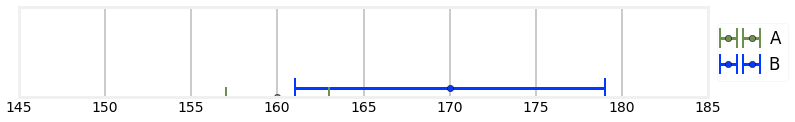

In [24]:
import gh_internal as gh
gh.plot_errorbar2()

In this graph sensor A returned a measurement of 160, and sensor B returned 170. The bars are *error bars* - they illustrate the possible range of error for the measurement. Hence, the actual value that A is measuring can be betwee 157 to 163, and B is measuring a value between 161 to 179.

I did not define it at the time, but this is a *uniform distribution*. A uniform distribution assigns equal probability to any event in the range. According to this model it is equally likely for sensor A to read 157, 160, or 163. Likewise, 161, 170, and 179 are equally likely. Any value outside these ranges have 0 probability. 

We can model this situation with Gaussians. I'll use $\mathcal{N}(160, 3^2)$ for sensor A, and $\mathcal{N}(170, 9^2)$ for sensor B. I've plotted these below with the uniform distribution error bars for comparison.

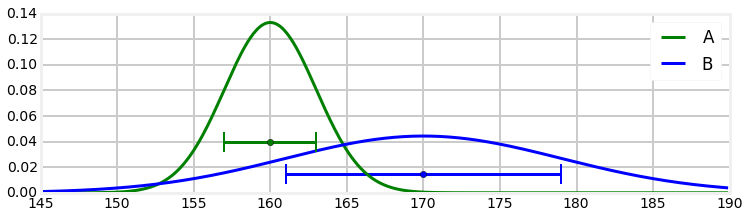

In [25]:
import book_format
with book_format.figsize(y=3):
    xs = np.arange(145, 190, 0.1)
    ys = [stats.gaussian(x, 160, 3**2) for x in xs]
    plt.plot(xs, ys, label='A', color='g')

    ys = [stats.gaussian(x, 170, 9**2) for x in xs]
    plt.plot(xs, ys, label='B', color='b')
    plt.legend();
    plt.errorbar(160, [0.04], xerr=[3], fmt='o', color='g', capthick=2, capsize=10)    
    plt.errorbar(170, [0.015], xerr=[9], fmt='o', color='b', capthick=2, capsize=10)

Using a uniform or Gaussian distribution is a modeling choice. Neither exactly describes reality. In most cases the Gaussian distribution is more realistic. Most sensors are more likely to return readings near the value being measured, and unlikely to return a reading far from that value. The Gaussian models this tendency. In contrast the uniform distribution assumes that any measurement within a range is equally likely.

Now let's see the *discrete distribution* used in the discrete Bayes filter. This model divides the range of possible values into discrete ranges and assigns a probability to each bucket. This assignment can be entirely arbitrary so long as the probabilities sum to one.

Let's plot the data for one sensor using a uniform distribution, a Gaussian distribution, and a discrete distribution.

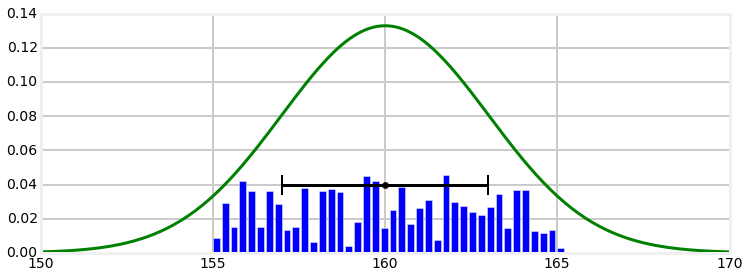

In [26]:
from random import random
xs = np.arange(145, 190, 0.1)
ys = [stats.gaussian(x, 160, 3**2) for x in xs]
belief = np.array([random() for _ in range(40)])
belief = belief / sum(belief)
x = np.linspace(155, 165, len(belief))
plt.gca().bar(x, belief, width=0.2)
plt.plot(xs, ys, label='A', color='g')
plt.errorbar(160, [0.04], xerr=[3], fmt='o', color='k', capthick=2, capsize=10)    
plt.xlim(150, 170);

I used random numbers to form the discrete distribution to illustrate that it can model any arbitrary probability distribution. This provides it with enormous power. With enough discrete buckets we can model the error characteristics of any sensor no matter how complicated. But with this power comes mathematical intractability. Multiplying or adding Gaussians takes two lines of math. Multiplying or adding a discrete distribution requires looping over the data, and we have no easy way to characterize the result. In contrast, multiplying two Gaussians results in another Gaussian, as does adding them. This regularity allows us to perform powerful analysis on the performance and behavior of our filters. Analyzing the performance characteristics of a filter based on a discrete distribution is extremely difficult to impossible.

There is no 'correct' choice here. Later in the book we will introduce the *particle filter* which uses a discrete distribution It is an extremely powerful technique because it can handle arbitrarily complex situations. This comes at the cost of very slow performance, and resistance to analytical analysis. 

For now we will ignore these matters and return to using Gaussians for the next several chapters. As we progress you will learn the strengths and limitations of using Gaussians in our mathematical models.

## Implementation in a Class

For many purposes the code above suffices. However, if you write enough of these filters the functions will become a bit annoying. For example, having to write

```python
pos = predict(pos[0], pos[1], movement, movement_variance)
```

is a bit cumbersome and error prone. Let's investigate how we might implement this in a form that makes our lives easier.

First, values for the process error and the measurement errors are often constant for a given problem, so we only want to specify them once. We can store them in instance variables in the class. Second, it is annoying to have to pass in the state (pos in the code snippet above) and then remember to assign the output of the function back to that state, so the state should also be an instance variable. Our first attempt might look like:

```python
class KalmanFilter1D:
    def __init__(self, state, state_var, measurement_var, movement_var):
        self.state = state
        self.state_var = state_var
        self.measurement_var = measurement_var
        self.movement_var = movement_var
```

That works, but I am going to use different naming. The Kalman filter literature uses math, not code. It uses single letter variables and I will start exposing you to them now. At first it seems impossibly terse, but as you become familiar with the notation you'll see that the math formulas in the textbooks will have an exact one-to-one correspondence with the code. Unfortunately there is not a lot of meaning behind the notation unless you have experience in the history of control theory; you will have to memorize them. If you do not make this effort you will never be able to read the literature or code written by others.

We will use `x` for the state (estimated value of the filter) and `P` for the variance of the state. `R` is the measurement error, and `Q` is the process (prediction) error. Almost every publication uses this notation, so learn it. This gives us:

```python
class KalmanFilter1D:
    def __init__(self, x0, P, R, Q):
        self.x = x0
        self.P = P
        self.R = R
        self.Q = Q
```
            
Now we can implement the `update()` and `predict()` methods. In the literature the measurement is usually named either `z` or `y`; I find `y` is too easy to confuse with the y axis of a plot, so I like `z`. I like to think I can hear a `z` in *measurement*, which helps me remember what `z` stands for. So for the update method we might write:

```python
def update(z):
    self.x = (self.P*z + self.x*self.R) / (self.P + self.R)
    self.P = 1 / (1/self.P + 1/self.R)
```

Finally, the movement is usually called `u`, and so we will use that. So for the predict method we might write:

```python
def predict(self, u):
    self.x += u
    self.P += self.Q
```

That give us the following code. Production code would require significant comments and error checking. However, in subsequent chapters we will develop Kalman filter code that works for any dimension. This class will never be more than a stepping stone for us, so I'll keep things simple.

In [27]:
class KalmanFilter1D:
    def __init__(self, x0, P, R, Q):
        self.x = x0
        self.P = P
        self.R = R
        self.Q = Q

    def update(self, z):
        self.x = (self.P*z + self.x*self.R) / (self.P + self.R)
        self.P = 1. / (1./self.P + 1./self.R)

    def predict(self, u=0.0):
        self.x += u
        self.P += self.Q

## Introduction to Designing a Filter

So far we have developed filters for a position sensor. We are used to this problem by now, and may feel ill-equipped to implement a Kalman filter for a different problem. To be honest, there is still quite a bit of information missing from this presentation. Following chapters will fill in the gaps. Still, lets get a feel for it by designing and implementing a Kalman filter for a thermometer. The sensor for the thermometer outputs a voltage that corresponds to the temperature that is being measured. We have read the manufacturer's specifications for the sensor, and it tells us that the sensor exhibits white noise with a standard deviation of 0.13 volts.

We can simulate the temperature sensor measurement with this function:

In [28]:
def volt(voltage, std):
    return voltage + (randn() * std)

Now we need to write the Kalman filter processing loop. As with our previous problem, we need to perform a cycle of predicting and updating. The sensing step probably seems clear - call `volt()` to get the measurement, pass the result into `update()` method, but what about the predict step? We do not have a sensor to detect 'movement' in the voltage, and for any small duration we expect the voltage to remain constant. How shall we handle this?

As always, we will trust in the math. We have no known movement, so we will set that to zero. However, that means that we are predicting that the temperature will never change. If that is true, then over time we should become extremely confident in our results. Once the filter has enough measurements it will become very confident that it can predict the subsequent temperatures, and this will lead it to ignoring measurements that result due to an actual temperature change. This is called a *smug* filter, and is something you want to avoid. So we will add a bit of error to our prediction step to tell the filter not to discount changes in voltage over time. In the code below I set `process_var = .05**2`. This is the expected variance in the change of voltage over each time step. I chose this value merely to be able to show how the variance changes through the update and predict steps. For an real sensor you would set this value for the actual amount of change you expect. For example, this would be an extremely small number if it is a thermometer for ambient air temperature in a house, and a high number if this is a thermocouple in a chemical reaction chamber. We will say more about selecting the actual value in the later chapters.

Let's see what happens. 

In [29]:
temp_change = 0
voltage_std = .13
process_var = .05**2
actual_voltage = 16.3

N = 50
zs = [volt(actual_voltage, voltage_std) for i in range(N)]
ps = []
estimates = []

kf = KalmanFilter1D(x0=25,         # initial state
                    P=1000,        # initial variance 
                                   # large # says 'who knows?'
                    R=variance,    # sensor noise
                    Q=process_var) # error in prediction

for i in range(N):
    kf.predict(temp_change)
    kf.update(zs[i])

    # save for latter plotting
    estimates.append(kf.x)
    ps.append(kf.P)

# plot the filter output and the variance
bp.plot_measurements(zs)
bp.plot_filter(estimates, var=np.array(ps))
bp.show_legend()
plt.show()
plt.plot(ps)
plt.title('Variance')
plt.show()
print('Variance converges to {:.3f}'.format(ps[-1]))

NameError: name 'variance' is not defined

The first plot shows the individual sensor measurements vs the filter output. Despite a lot of noise in the sensor we quickly discover the approximate voltage of the sensor. In the run I just completed at the time of authorship, the last voltage output from the filter is $16.213$, which is quite close to the $16.4$ used by the `volt()` function. On other runs I have gotten larger and smaller results.

Spec sheets are what they sound like - specifications. Any individual sensor will exhibit different performance based on normal manufacturing variations. Values are often maximums - the spec is a guarantee that the performance will be at least that good. If you buy an expensive piece of equipment it often comes with a sheet of paper displaying the test results of your specific item; this is usually very trustworthy. On the other hand, if this is a cheap sensor it is likely it received little to no testing prior to being sold. Manufacturers typically test a small subset of their output to verify that a sample falls within the desired performance range. If you have a critical application you will need to read the specification sheet carefully to figure out exactly what they mean by their ranges. Do they guarantee their number is a maximum, or is it, say, the $3\sigma$ error rate? Is every item tested? Is the variance normal, or some other distribution? Finally, manufacturing is not perfect. Your part might be defective and not match the performance on the sheet.

For example, I am looking at a data sheet for an airflow sensor. There is a field *Repeatability*, with the value $\pm 0.50\%$. Is this a Gaussian? Is there a bias? For example, perhaps the repeatability is nearly 0.0% at low temperatures, and always nearly  +0.50 at high temperatures. Data sheets for electrical components often contain a section of "Typical Performance Characteristics". These are used to capture information that cannot be easily conveyed in a table. For example, I am looking at a chart showing output voltage vs current for a LM555 timer. There are three curves showing the performance at different temperatures. The response is ideally linear, but all three lines are curved. This clarifies that errors in voltage outputs are probably not Gaussian - in this chip's case higher temperatures leads to lower voltage output, and the voltage output is quite nonlinear if the input current is very high. 

As you might guess, modeling the performance of your sensors is one of the harder parts of creating a Kalman filter that performs well. 

### Animation

For those reading this in a browser here is an animation showing the filter working. If you are not using a browser you can see this plot at https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/animations/05_volt_animate.gif.

The top plot in the animation draws a green line for the predicted next voltage, then a red '+' for the actual measurement, draws a light red line to show the residual, and then draws a blue line to the filter's output. You can see that when the filter starts the corrections made are quite large, but after only a few updates the filter only adjusts its output by a small amount even when the measurement is far from it. 

The lower plot shows the Gaussian belief as the filter innovates. When the filter starts the Gaussian curve is centered over 25, our initial guess for the voltage, and is very wide and short due to our initial uncertainty. But as the filter innovates, the Gaussian quickly moves to about 16.0 and becomes taller, reflecting the growing confidence that the filter has in it's estimate for the voltage. You will also note that the Gaussian's height bounces up and down a little bit. If you watch closely you will see that the Gaussian becomes a bit shorter and more spread out during the prediction step, and becomes taller and narrower as the filter incorporates another measurement.

<img src='animations/05_volt_animate.gif'>

Think of this animation in terms of the g-h filter. At each step the g-h filter makes a prediction, takes a measurement, computes the residual (the difference between the prediction and the measurement), and then selects a point on the residual line based on the scaling factor *g*. The Kalman filter is doing exactly the same thing, except that the scaling factor *g* varies with time. As the filter becomes more confident in its state the scaling factor favors the filter's prediction over the measurement. 

## Exercise: Plot Histogram of Measurements

Write a function that runs the Kalman filter many times and record what value the voltage converges to each time. Plot this as a histogram. Use plt.hist(data, bins=100) to plot the histogram. After 10,000 runs do the results look normally distributed? Does this match your intuition of what should happen?

In [ ]:
#Your code here

### Solution

In [ ]:
variance = 2.13**2
process_var = 0.1**2
actual_voltage = 16.3

def VKF():
    N = 50
    voltage = (14, 1000)
    for i in range(N):
        Z = volt(actual_voltage, variance)
        voltage = predict(voltage[0], voltage[1], 0, process_var)
        voltage = update(voltage[0], voltage[1], Z, variance)
    return voltage[0]

vs = []
for i in range(10000):
    vs.append(VKF())
plt.hist(vs, bins=100, color='#e24a33');

### Discussion

The results do in fact look like a normal distribution. Each voltage is Gaussian, and the *Central Limit Theorem* guarantees that a large number of Gaussians is normally distributed. 

## Example: Extreme Amounts of Noise

With the dog filter I didn't put a lot of noise in the signal, and I also 'correctly guessed' that the dog was at position 0. How does the filter perform in real world conditions? I will start by injecting more noise in the RFID sensor while leaving the process variance at 2 m$^2$.  I will inject an extreme amount of noise - noise that apparently swamps the actual measurement. What does your intuition say about the filter's performance if the has a standard deviation of 300 meters?. In other words, an actual position of 1.0 m might be reported as 287.9 m, or -589.6 m, or any other number in roughly that range. Think about it before you scroll down.

In [ ]:
velocity = 1
sensor_var = 300**2
process_var = 2
pos = (0,500)
N = 1000
dog = DogSimulation(pos[0], velocity, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for i in range(N):
    pos = predict(pos[0], pos[1], velocity, process_var)    
    pos = update(pos[0], pos[1], zs[i], sensor_var)
    ps.append(pos[0])

bp.plot_measurements(zs, lw=1)
bp.plot_filter(ps)
plt.legend(loc='best');

In this example the noise is extreme yet the filter still outputs a nearly straight line! This is an astonishing result! What do you think might be the cause of this performance? 

We get a nearly straight line because our process error is small. A small process error tells the filter that the prediction is very trustworthy, and the prediction is a straight line, so the filter outputs a straight line. 

## Example: Incorrect Process Variance

That last filter looks fantastic! Why wouldn't we set the process variance very low, as it guarantees the result will be straight and smooth?

The process variance tells the filter how much the system is changing over time. If you lie to the filter by setting this number artificially low the filter will not be able to react to changes that are happening. Let's have the dog increase his velocity by a small amount at each time step and see how the filter performs with a process variance of 0.001 m$^2$.

In [ ]:
velocity = 1
sensor_var = 20
process_var = .001
pos = (0,500)
N = 100
dog = DogSimulation(pos[0], velocity, sensor_var, process_var*10000)
zs = []
for _ in range(N):
    dog.velocity += 0.04
    zs.append(dog.move_and_sense())
ps = []

for i in range(N):
    pos = predict(pos[0], pos[1], velocity, process_var)    
    pos = update(pos[0], pos[1], zs[i], sensor_var)
    ps.append(pos[0])

bp.plot_measurements(zs, lw=1)
bp.plot_filter(ps)
plt.legend(loc=4);

It is easy to see that the filter is not correctly responding to the measurements. The measurements  clearly indicate that the dog is changing speed but the filter has been told that it's predictions are nearly perfect so it almost entirely ignores the measurements. I encourage you to adjust the amount of movement in the dog vs process variance. We will also be studying this topic much more in the later chapters. The key point is the filter will do what you tell it to. There is nothing in the math that allows the filter to recognize that you have lied to it about the variance in the measurements and process model.

## Example: Bad Initial Estimate


Now let's lets look at the results when we make a bad initial estimate of position. To avoid obscuring the results I'll reduce the sensor variance to 30, but set the initial position to 1000 meters. Can the filter recover from a 1000 meter error?

In [ ]:
velocity = 1
sensor_var = 30
process_var = 2
pos = (1000, 500)
N = 100
dog = DogSimulation(0, velocity, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for i in range(N):
    pos = predict(pos[0], pos[1], velocity, process_var)    
    pos = update(pos[0], pos[1], zs[i], sensor_var)
    ps.append(pos[0])

bp.plot_measurements(zs, lw=1)
bp.plot_filter(ps)
plt.legend(loc=4);

Again the answer is yes! Because we are relatively sure about our belief in the sensor ($\sigma^2=30$) after only the first step we have changed our position estimate from 1000 m to roughly 60 m. After another 5-10 measurements we have converged to the correct value. This is how we get around the chicken and egg problem of initial guesses. In practice we would likely assign the first measurement from the sensor as the initial value, but you can see it doesn't matter much if we wildly guess at the initial conditions - the Kalman filter still converges so long as the filter variances are chosen to match the actual process and measurement variances.

## Example: Large Noise and Bad Initial Estimate

What about the worst of both worlds, large noise and a bad initial estimate?

In [ ]:
sensor_var = 30000
process_var = 2
pos = (1000, 500)
N = 1000
dog = DogSimulation(0, velocity, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for i in range(N):
    pos = predict(pos[0], pos[1], velocity, process_var) 
    pos = update(pos[0], pos[1], zs[i], sensor_var)
    ps.append(pos[0])

bp.plot_measurements(zs, lw=1)
bp.plot_filter(ps)
plt.legend(loc=4);

This time the filter struggles. Notice that the previous example only computed 100 updates, whereas this example uses 1000. By my eye it takes the filter 400 or so iterations to become reasonable accurate, but maybe over 600 before the results are good. Kalman filters are good, but we cannot expect miracles. If we have extremely noisy data and extremely bad initial conditions, this is as good as it gets.

Finally, let's implement the suggestion of using the first measurement as the initial position.

In [ ]:
sensor_var = 30000
process_var = 2
N = 1000
dog = DogSimulation(0, velocity, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

pos = (zs[0], 500)
ps = []
for i in range(N):
    pos = predict(pos[0], pos[1], velocity, process_var)
    pos = update(pos[0], pos[1], zs[i], sensor_var)
    ps.append(pos[0])

bp.plot_measurements(zs, lw=1)
bp.plot_filter(ps)
plt.legend(loc='best');

This simple change significantly improves the results. On some runs it takes 200 iterations or so to settle to a good solution, but other runs it converges very rapidly. This all depends on the amount of noise in the first measurement. A large amount of noise causes the initial estimate to be far from the dog's position.

200 iterations may seem like a lot, but the amount of noise we are injecting is truly huge. In the real world we use sensors like thermometers,  laser range finders, GPS satellites, computer vision, and so on. None have the enormous errors in these examples. A reasonable variance for a cheap thermometer might be 0.2 C$^{\circ 2}$, and our code is using 30,000 C$^{\circ 2}$.

## Exercise: Interactive Plots

Implement the Kalman filter using Jupyter Notebook's animation features to allow you to modify the various constants in real time using sliders. Refer to the section **Interactive Gaussians** in the **Gaussians** chapter to see how to do this. You will use the `interact()` function to call a calculation and plotting function. Each parameter passed into `interact()` automatically gets a slider created for it. I have written the boilerplate for this; you fill in the required code.

In [ ]:
from IPython.html.widgets import interact, interactive, fixed
from IPython.html.widgets import FloatSlider

def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       velocity, 
                       process_noise):
    # your code goes here
    pass

interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=FloatSlider(value=5, min=0, max=100), 
         velocity=FloatSlider(value=1, min=-2., max=2.), 
         process_noise=FloatSlider(value=5, min=0, max=100.));

### Solution

One possible solution follows. We have sliders for the start position, the amount of noise in the sensor, the amount we move in each time step, and how much movement error there is. Process noise is perhaps the least clear - it models how much the dog wanders off course at each time step, so we add that into the dog's position at each step. I set the random number generator seed so that each redraw uses the same random numbers, allowing us to compare the graphs as we move the sliders.

In [ ]:
from numpy.random import seed 
def plot_kalman_filter(start_pos, 
                       sensor_noise, 
                       velocity,
                       process_noise):
    N = 20
    zs, ps = [], []   
    seed(303)
    dog = DogSimulation(start_pos, velocity, sensor_noise, process_noise)
    zs = [dog.move_and_sense() for _ in range(N)]
    pos = (0., 1000.) # mean and variance

    for i in range(N):    
        pos = predict(pos[0], pos[1], velocity, process_noise)
        pos = update(pos[0], pos[1], zs[i], sensor_noise)
        ps.append(pos[0])

    plt.plot(zs, c='r', linestyle='dashed', label='measurement')
    plt.plot(ps, c='#004080', alpha=0.7, label='filter')
    plt.legend(loc=4);

interact(plot_kalman_filter,
         start_pos=(-10, 10), 
         sensor_noise=FloatSlider(value=5, min=0., max=100), 
         velocity=FloatSlider(value=1, min=-2., max=2.), 
         process_noise=FloatSlider(value=.1, min=0, max=40));

## Exercise - Nonlinear Systems

Our equations for the Kalman filter are linear:

$$\begin{aligned}
\mathcal{N}(\mu,\, \sigma^2) &= \mathcal{N}(\mu,\, \sigma^2) + \mathcal{N}(\mu_\mathtt{move},\, \sigma^2_\mathtt{move})\\
\mathcal{N}(\mu,\, \sigma^2) &= \mathcal{N}(\mu,\, \sigma^2)  \times \mathcal{N}(\mu_\mathtt{z},\, \sigma^2_\mathtt{z})
\end{aligned}$$

Do you suppose that this filter works well or poorly with nonlinear systems?

Implement a Kalman filter that uses the following equation to generate the measurement value

```python
for i in range(100):
    Z = math.sin(i/3.) * 2
```
    
Adjust the variance and initial positions to see the effect. What is, for example, the result of a very bad initial guess?

In [ ]:
#enter your code here.

### Solution

In [ ]:
sensor_var = 30
process_var = 2
pos = (100,500)

zs, ps = [], []

for i in range(100):
    pos = predict(pos[0], pos[1], velocity, process_var)

    Z = math.sin(i/3.)*2
    zs.append(Z)
    
    pos = update(pos[0], pos[1], Z, sensor_var)
    ps.append(pos[0])

plt.plot(zs, c='r', linestyle='dashed', label='input')
plt.plot(ps, c='#004080', label='filter')
plt.legend(loc='best');

### Discussion

Here we use a bad initial guess of 100. We can see that the filter never 'acquires' the signal. Note now the peak of the filter output always lags the peak of the signal by a small amount, and how the filtered signal does not come very close to capturing the high and low peaks of the input signal.

If we recall the **g-h Filter** chapter we can understand what is happening here. The structure of the g-h filter requires that the filter output chooses a value part way between the prediction and measurement. A varying signal like this one is always accelerating, whereas our process model assumes constant velocity, so the filter is mathematically guaranteed to always lag the input signal. 

Maybe we didn't adjust things 'quite right'. After all, the output looks like an offset sin wave. Let's test this assumption.

## Exercise - Noisy Nonlinear Systems

Implement the same system, but add noise to the measurement.

In [ ]:
#enter your code here

### Solution

In [ ]:
sensor_var = 30
process_var = 2
pos = (100,500)

zs, ps = [], []

for i in range(100):
    pos = predict(pos[0], pos[1], velocity, process_var)

    Z = math.sin(i/3.)*2 + randn()*1.2
    zs.append(Z)
    
    pos = update(pos[0], pos[1], Z, sensor_var)
    ps.append(pos[0])

p1, = plt.plot(zs, c='r', linestyle='dashed', label='measurement')
p2, = plt.plot(ps, c='#004080', label='filter')
plt.legend(loc='best');

### Discussion

This is terrible! The output is not at all like a sin wave, except in the grossest way. With linear systems we could add extreme amounts of noise to our signal and still extract a very accurate result, but here even modest noise creates a very bad result.

Very shortly after practitioners began implementing Kalman filters they recognized the poor performance of them for nonlinear systems and began devising ways of dealing with it. Later chapters are devoted to this problem.

## Fixed Gain Filters

Embedded computers usually have extremely limited processors; many do not have floating point circuitry. These simple equations can impose a heavy burden on the chip. This is less true as technology advances, but do not underestimate the value of spending 10 cents less on a processor when millions will be used.

In the example above the variance of the filter converged to a fixed value. This will always happen if the variance of the measurement and process is a constant. You can take advantage of this fact by running simulations to determine what the variance converges to. Then you can hard code this value into your filter. So long as you initialize the filter to a good starting guess (I recommend using the first measurement as your initial value) the filter will perform very well. 

So for embedded applications it is common to perform many simulations to determine a fixed Kalman gain value, and then hard code this into the application. Besides reducing chip cost this also makes verifying correctness easier. If you are making a medical device, a device that is being sent into space, or a device that will have one million copies made then an error can cost lives, end a scientific mission, or and/or cost millions of dollars. A professional engineer does everything she can to reduce and eliminate risks.

## Derivation From Bayes Theorem (Optional)


I gave you the equations for the product of two Gaussians but did not derive them for you. They are a direct result of applying Bayes rules to Gaussians, however. You don't need to understand this section to read the rest of the book or to use Kalman filters. You may need to know this if you read the literature, much of which is written in terms of Bayes theorem. It's a bit of neat algebra, so why not read on?

We can state the problem as: let the prior be $N(\mu_p, \sigma_p^2)$, and measurement be $z \propto N(z, \sigma_z^2)$. What is the posterior  x given the measurement z?

Write the posterior as $P(x|z)$. Now we can use Bayes Theorem to state

$$P(x|z) = \frac{P(z|x)P(x)}{P(z)}$$

$P(z)$ is a normalizing constant, so we can create a proportinality

$$P(x|z) \propto P(z|x)P(x)$$

Now we subtitute in the equations for the Gaussians, which are

$$P(z|x) = \frac{1}{\sqrt{2\pi\sigma_z^2}}\exp \Big[-\frac{(z-x)^2}{2\sigma_z^2}\Big]$$

$$P(x) = \frac{1}{\sqrt{2\pi\sigma_p^2}}\exp \Big[-\frac{(x-\mu_p)^2}{2\sigma_p^2}\Big]$$

We can drop the leading terms, as they are constants, giving us

$$\begin{aligned}
P(x|z) &\propto \exp \Big[-\frac{(z-x)^2}{2\sigma_z^2}\Big]\exp \Big[-\frac{(x-\mu_p)^2}{2\sigma_p^2}\Big]\\
&\propto \exp \Big[-\frac{(z-x)^2}{2\sigma_z^2}-\frac{(x-\mu_p)^2}{2\sigma_p^2}\Big] \\
&\propto \exp \Big[-\frac{1}{2\sigma_z^2\sigma_p^2}[\sigma_p^2(z-x)^2-\sigma_z^2(x-\mu_p)^2]\Big]
\end{aligned}$$

Now we multiply out the squared terms and group in terms of the posterior $x$.

$$\begin{aligned}
P(x|z) &\propto \exp \Big[-\frac{1}{2\sigma_z^2\sigma_p^2}[\sigma_p^2(z^2 -2xz + x^2) + \sigma_z^2(x^2 - 2x\mu_p+\mu_p^2)]\Big ] \\
&\propto \exp \Big[-\frac{1}{2\sigma_z^2\sigma_p^2}[x^2(\sigma_p^2+\sigma_z^2)-2x(\sigma_z^2\mu_p + \sigma_p^2z) + (\sigma_p^2z^2+\sigma_z^2\mu_p^2)]\Big ]
\end{aligned}$$

The last parentheses do not contain the posterior $x$, so it can be treated as a constant and discarded.

$$P(x|z) \propto \exp \Big[-\frac{1}{2}\frac{x^2(\sigma_p^2+\sigma_z^2)-2x(\sigma_z^2\mu_p + \sigma_p^2z)}{\sigma_z^2\sigma_p^2}\Big ]
$$

Divide numerator and denominator by $\sigma_p^2+\sigma_z^2$ to get

$$P(x|z) \propto \exp \Big[-\frac{1}{2}\frac{x^2-2x(\frac{\sigma_z^2\mu_p + \sigma_p^2z}{\sigma_p^2+\sigma_z^2})}{\frac{\sigma_z^2\sigma_p^2}{\sigma_p^2+\sigma_z^2}}\Big ]
$$

Proportionality lets us create or delete constants at will, so we can factor this into

$$P(x|z) \propto \exp \Big[-\frac{1}{2}\frac{(x-\frac{\sigma_z^2\mu_p + \sigma_p^2z}{\sigma_p^2+\sigma_z^2})^2}{\frac{\sigma_z^2\sigma_p^2}{\sigma_p^2+\sigma_z^2}}\Big ]
$$

A Gaussian is

$$N(m,\, s^2) \propto \exp\Big [-\frac{1}{2}\frac{(x - m)^2}{s^2}\Big ]$$

So we can see that $P(x|z)$ has a mean of

$$\mu_\mathtt{posterior} =\frac{\sigma_z^2\mu_p + \sigma_p^2z}{\sigma_p^2+\sigma_z^2}$$

and a variance of
$$\begin{aligned}
\sigma_\mathtt{posterior} &=\frac{\sigma_z^2\sigma_p^2}{\sigma_p^2+\sigma_z^2} 
= \frac{1}{\frac{1}{\sigma_p^2}+\frac{1}{\sigma_z^2}}
\end{aligned}$$

which are the equations that we have been using.

## Summary

The one dimensional Kalman filter that we describe in this chapter is a special, restricted case of the more general filter. Most texts do not discuss the one dimensional form. However, I think it is a vital stepping stone. We started the book with the g-h filter, then implemented the discrete Bayes filter, and now implemented the one dimensional Kalman filter. I have tried to show you that each of these filters use the same algorithm and reasoning. The mathematics of the Kalman filter that we will learn shortly is fairly sophisticated, and it can be difficult to understand the underlying simplicity of the filter. That sophistication comes with significant benefits: the generalized filter will markedly outperform the filters in this chapter.

This chapter takes time to assimilate. To truly understand it you will probably have to work through this chapter several times. I encourage you to change the various constants in the code and observe the results. Convince yourself that Gaussians are a good representation of a unimodal belief of  the position of a dog in a hallway, the position of an aircraft in the sky, or the temperature of a chemical reaction chamber. Then convince yourself that multiplying Gaussians truly does compute a new belief from your prior belief and the new measurement. Finally, convince yourself that if you are measuring movement, that adding the Gaussians together updates your belief. 

If you do not fully understand this, reread this chapter. Try implementing the filter from scratch, just by looking at the equations and reading the text. Change the constants. Maybe try to implement a different tracking problem, like tracking stock prices. Experimentation will build your intuition and understanding of how these marvelous filters work.

Most of all, spend enough time with the **Full Description of the Algorithm** section to ensure you understand the algorithm and how it relates to the g-h filter and discrete Bayes filter. There is just one 'trick' here - selecting a value somewhere between a prediction and a measurement. Each algorithm performs that trick with different math, but all use the same logic.